In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, plot_confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import ast
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.preprocessing import LabelBinarizer
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.model_selection import GridSearchCV

In [2]:
import model_helper_functions

In [3]:
DATA_PATH = r"C:\Users\SHUBHAM KUMAR SINGH\Desktop\data"
PRE_PROCESSED_DATA_FILE_NAME = 'news_dataset_pre_processed.csv'
RANDOM_STATE = 42
pd.options.display.max_seq_items = 20
pd.options.display.max_rows = 50

In [4]:
df = pd.read_csv(r"C:\Users\SHUBHAM KUMAR SINGH\Desktop\data\datanews_dataset_pre_processed.csv", 
                 low_memory = False, 
                 usecols = ['title', 'text', 'label', 'clean_text_tokens', 'clean_title_tokens'])

In [5]:
df.clean_text_tokens = df.clean_text_tokens.map(ast.literal_eval)
df.clean_title_tokens = df.clean_title_tokens.map(ast.literal_eval)

In [6]:
df.head()

,title,text,label,clean_text_tokens,clean_title_tokens
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,fake,"[donald, trump, just, couldn, wish, all, ameri...","[donald, trump, sends, out, embarrassing, new,..."
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,fake,"[house, intelligence, committee, chairman, dev...","[drunk, bragging, trump, staffer, started, rus..."
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",fake,"[on, it, was, revealed, that, former, milwauke...","[sheriff, david, clarke, becomes, an, internet..."
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",fake,"[on, christmas, day, donald, trump, announced,...","[trump, is, so, obsessed, he, even, has, obama..."
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,fake,"[pope, francis, used, his, annual, christmas, ...","[pope, francis, just, called, out, donald, tru..."


In [7]:
y = df.label
X = df.drop('label', axis=1)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                   test_size = 0.2,
                                                   random_state = RANDOM_STATE,
                                                   stratify = y)

In [9]:
X_train.shape

(30910, 4)

In [10]:
X_test.shape


(7728, 4)

In [11]:
le = LabelEncoder()


In [12]:
y_train_enc = le.fit_transform(y_train)


In [13]:
y_test_enc = le.transform(y_test)


In [14]:
def train_and_eval_model(X_train, X_test, y_train_enc, y_test_enc, classes_,
                        preprocessor, tokenizer, max_df=1.0, ngram_range = (1, 1),
                        min_samples_split=2,
                        max_depth=None):
    """
    Train and Evaluate and Bag of Words Representation with a Random Forest
    classifier.
    """
    
    pipeline = Pipeline([
    ('bow',CountVectorizer(min_df = 5, 
                           preprocessor = preprocessor, 
                           tokenizer = tokenizer, 
                           max_df = max_df, 
                           ngram_range = ngram_range)),  
    ('classifier', RandomForestClassifier(n_jobs = -1, 
                                          random_state = RANDOM_STATE, 
                                          min_samples_split = min_samples_split, 
                                          max_depth = max_depth)),
    ])
    
    pipeline.fit(X_train,y_train_enc)
    
    model_helper_functions.confustion_matrix_and_classification_report(pipeline, 
                                                X_train, 
                                                y_train_enc, 
                                                classes_, 
                                               'Training')

    model_helper_functions.confustion_matrix_and_classification_report(pipeline, 
                                                X_test, 
                                                y_test_enc, 
                                                classes_,
                                                'Test')
    
    return pipeline

Classification Report for Training Set
              precision    recall  f1-score   support

        fake       1.00      1.00      1.00     13957
        true       1.00      1.00      1.00     16953

    accuracy                           1.00     30910
   macro avg       1.00      1.00      1.00     30910
weighted avg       1.00      1.00      1.00     30910



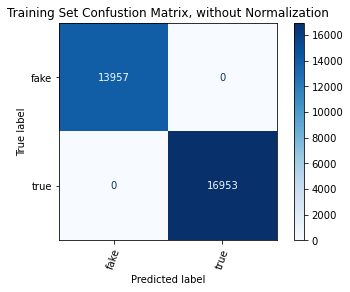

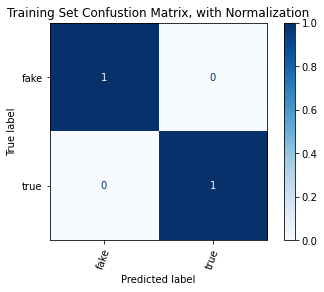

Classification Report for Test Set
              precision    recall  f1-score   support

        fake       0.94      0.93      0.93      3490
        true       0.94      0.95      0.95      4238

    accuracy                           0.94      7728
   macro avg       0.94      0.94      0.94      7728
weighted avg       0.94      0.94      0.94      7728



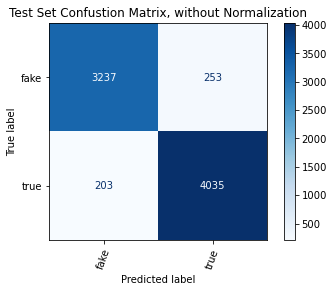

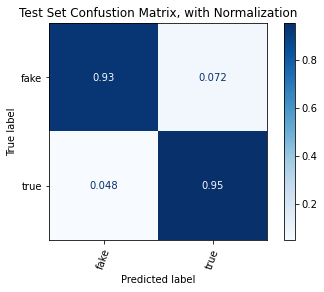

In [15]:
pipeline = train_and_eval_model(X_train = X_train['clean_title_tokens'], 
                                 X_test = X_test['clean_title_tokens'], 
                                 y_train_enc = y_train_enc, 
                                 y_test_enc = y_test_enc, 
                                 classes_ = le.classes_, 
                                 preprocessor = model_helper_functions.passthrough, 
                                 tokenizer = model_helper_functions.passthrough)

In [16]:
feature_importances = pd.DataFrame(pipeline['classifier'].feature_importances_, 
                                       index = pipeline['bow'].get_feature_names(), 
                                       columns = ['importance']).sort_values('importance', 
                                                                             ascending=False)
    
feature_importances.head(20)

,importance
VIDEO,0.062623
the,0.036216
U.S.,0.030962
!,0.029166
video,0.027032
WATCH,0.022678
says,0.014721
is,0.014565
and,0.014378
just,0.013250


Classification Report for Training Set
              precision    recall  f1-score   support

        fake       1.00      1.00      1.00     13957
        true       1.00      1.00      1.00     16953

    accuracy                           1.00     30910
   macro avg       1.00      1.00      1.00     30910
weighted avg       1.00      1.00      1.00     30910



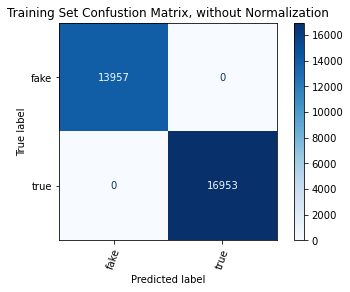

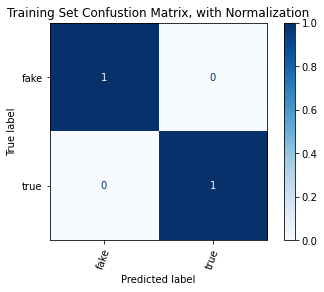

Classification Report for Test Set
              precision    recall  f1-score   support

        fake       0.94      0.90      0.92      3490
        true       0.92      0.96      0.94      4238

    accuracy                           0.93      7728
   macro avg       0.93      0.93      0.93      7728
weighted avg       0.93      0.93      0.93      7728



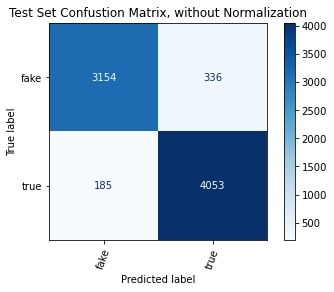

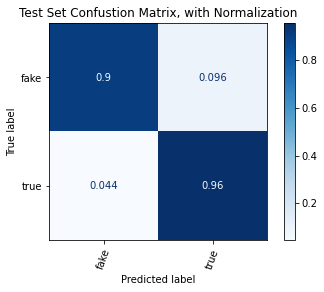

In [17]:
pipe_sw_removed = train_and_eval_model(X_train = X_train['clean_title_tokens'], 
                                 X_test = X_test['clean_title_tokens'], 
                                 y_train_enc = y_train_enc, 
                                 y_test_enc = y_test_enc, 
                                 classes_ = le.classes_, 
                                 preprocessor = model_helper_functions.passthrough, 
                                 tokenizer = model_helper_functions.remove_stopwords)

In [18]:
feat_imp_sw_removed = pd.DataFrame(pipe_sw_removed['classifier'].feature_importances_, 
                                       index = pipe_sw_removed['bow'].get_feature_names(), 
                                       columns = ['importance']).sort_values('importance', 
                                                                             ascending=False)
feat_imp_sw_removed.head(20)

,importance
VIDEO,0.082567
video,0.034551
U.S.,0.034298
!,0.031124
WATCH,0.023127
says,0.019187
hillary,0.016034
GOP,0.014017
BREAKING,0.009561
TWEETS,0.009523


Classification Report for Training Set
              precision    recall  f1-score   support

        fake       1.00      1.00      1.00     13957
        true       1.00      1.00      1.00     16953

    accuracy                           1.00     30910
   macro avg       1.00      1.00      1.00     30910
weighted avg       1.00      1.00      1.00     30910



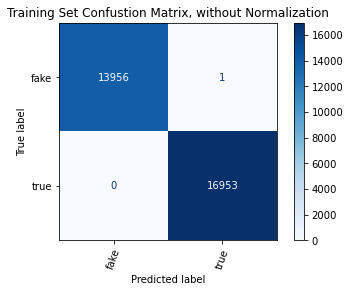

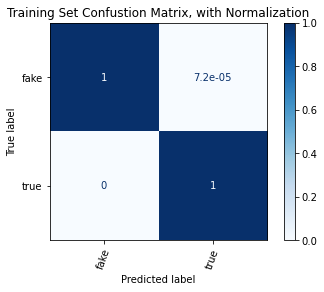

Classification Report for Test Set
              precision    recall  f1-score   support

        fake       0.93      0.90      0.92      3490
        true       0.92      0.95      0.93      4238

    accuracy                           0.93      7728
   macro avg       0.93      0.92      0.92      7728
weighted avg       0.93      0.93      0.93      7728



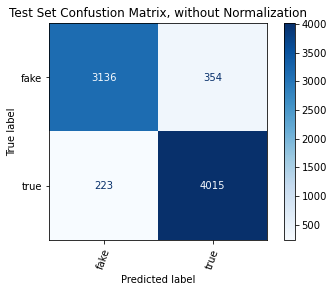

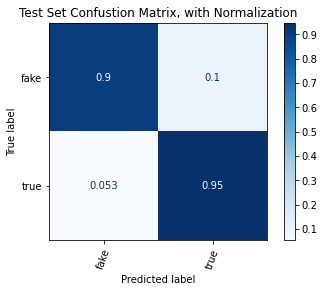

In [19]:
pipe_lc_sw_rm = train_and_eval_model(X_train = X_train['clean_title_tokens'], 
                     X_test = X_test['clean_title_tokens'], 
                     y_train_enc = y_train_enc, 
                     y_test_enc = y_test_enc, 
                     classes_ = le.classes_, 
                     preprocessor = model_helper_functions.lowercase_tokens, 
                     tokenizer = model_helper_functions.remove_stopwords)

In [20]:
feat_imp_lc_sw_rm = pd.DataFrame(pipe_lc_sw_rm['classifier'].feature_importances_, 
                                       index = pipe_lc_sw_rm['bow'].get_feature_names(), 
                                       columns = ['importance']).sort_values('importance', 
                                                                             ascending=False)
feat_imp_lc_sw_rm.head(20)

,importance
video,0.111507
u.s.,0.035080
!,0.032135
watch,0.028169
hillary,0.021249
says,0.018711
gop,0.014781
trump,0.013219
breaking,0.010839
donald,0.009054


Classification Report for Training Set
              precision    recall  f1-score   support

        fake       1.00      1.00      1.00     13957
        true       1.00      1.00      1.00     16953

    accuracy                           1.00     30910
   macro avg       1.00      1.00      1.00     30910
weighted avg       1.00      1.00      1.00     30910



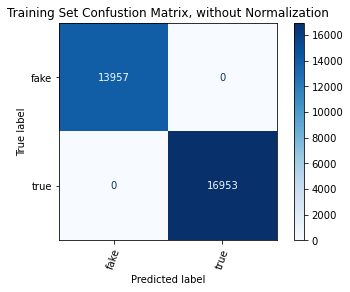

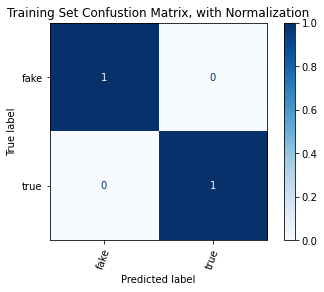

Classification Report for Test Set
              precision    recall  f1-score   support

        fake       0.93      0.90      0.92      3490
        true       0.92      0.95      0.93      4238

    accuracy                           0.93      7728
   macro avg       0.93      0.92      0.92      7728
weighted avg       0.93      0.93      0.93      7728



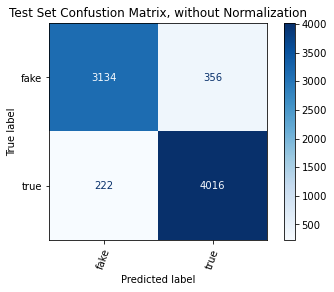

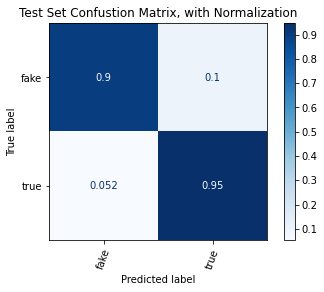

In [21]:
pipe_sw_rm_lc_ng = train_and_eval_model(X_train = X_train['clean_title_tokens'], 
                                         X_test = X_test['clean_title_tokens'], 
                                         y_train_enc = y_train_enc, 
                                         y_test_enc = y_test_enc, 
                                         classes_ = le.classes_, 
                                         preprocessor = model_helper_functions.lowercase_and_remove_stopwords, 
                                         tokenizer = model_helper_functions.passthrough, 
                                         ngram_range = (1, 2))

In [22]:
feat_imp_sw_rm_lc_ng = pd.DataFrame(pipe_sw_rm_lc_ng['classifier'].feature_importances_, 
                                       index = pipe_sw_rm_lc_ng['bow'].get_feature_names(), 
                                       columns = ['importance']).sort_values('importance', 
                                                                             ascending=False)
feat_imp_sw_rm_lc_ng.head(20)

,importance
video,0.100158
u.s.,0.031169
!,0.027140
watch,0.023414
hillary,0.019088
says,0.015889
gop,0.014911
trump,0.011288
breaking,0.010870
tweets,0.008760


In [23]:
X_train['title_and_text'] = X_train['clean_title_tokens'] + X_train['clean_text_tokens']
X_test['title_and_text'] = X_test['clean_title_tokens'] + X_test['clean_text_tokens']

C:\Users\SHUBHA~1\AppData\Local\Temp/ipykernel_2552/1450276812.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['title_and_text'] = X_train['clean_title_tokens'] + X_train['clean_text_tokens']
C:\Users\SHUBHA~1\AppData\Local\Temp/ipykernel_2552/1450276812.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['title_and_text'] = X_test['clean_title_tokens'] + X_test['clean_text_tokens']


Classification Report for Training Set
              precision    recall  f1-score   support

        fake       1.00      1.00      1.00     13957
        true       1.00      1.00      1.00     16953

    accuracy                           1.00     30910
   macro avg       1.00      1.00      1.00     30910
weighted avg       1.00      1.00      1.00     30910



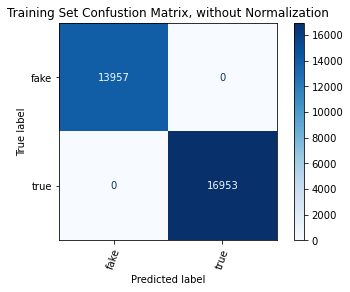

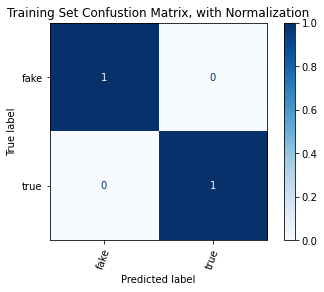

Classification Report for Test Set
              precision    recall  f1-score   support

        fake       0.99      0.97      0.98      3490
        true       0.98      0.99      0.98      4238

    accuracy                           0.98      7728
   macro avg       0.98      0.98      0.98      7728
weighted avg       0.98      0.98      0.98      7728



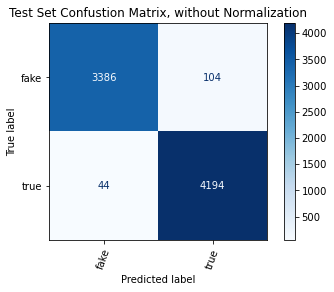

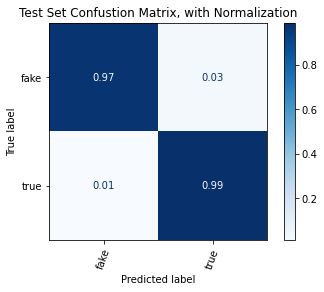

In [24]:
pipe_title_text = train_and_eval_model(X_train['title_and_text'], 
                                       X_test['title_and_text'],
                                       y_train_enc, 
                                       y_test_enc, 
                                       le.classes_, 
                                       model_helper_functions.passthrough, 
                                       model_helper_functions.passthrough)

In [25]:
feat_imp_title_text = pd.DataFrame(pipe_title_text['classifier'].feature_importances_, 
                                       index = pipe_title_text['bow'].get_feature_names(), 
                                       columns = ['importance']).sort_values('importance', 
                                                                             ascending=False)
feat_imp_title_text.head(30)

,importance
said,0.024665
image,0.021053
via,0.017880
U.S.,0.015883
WASHINGTON,0.014920
VIDEO,0.012557
you,0.011855
just,0.011363
video,0.010997
!,0.010725


Classification Report for Training Set
              precision    recall  f1-score   support

        fake       1.00      1.00      1.00     13957
        true       1.00      1.00      1.00     16953

    accuracy                           1.00     30910
   macro avg       1.00      1.00      1.00     30910
weighted avg       1.00      1.00      1.00     30910



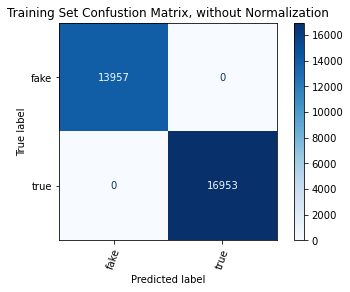

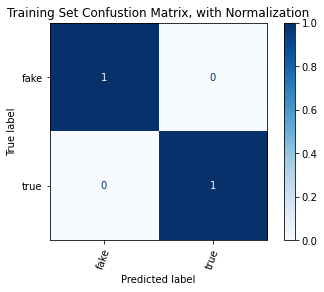

Classification Report for Test Set
              precision    recall  f1-score   support

        fake       0.98      0.96      0.97      3490
        true       0.96      0.99      0.98      4238

    accuracy                           0.97      7728
   macro avg       0.97      0.97      0.97      7728
weighted avg       0.97      0.97      0.97      7728



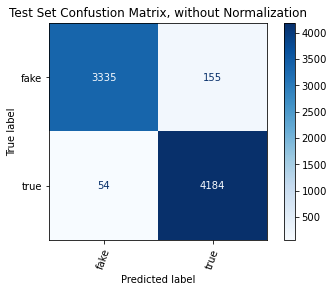

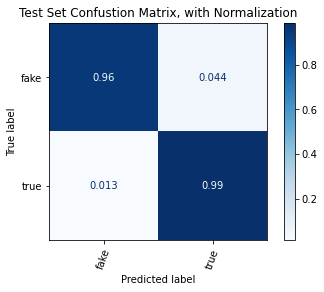

In [32]:
pipe_title_text_lc_lemma = train_and_eval_model(X_train['title_and_text'], 
                                       X_test['title_and_text'],
                                       y_train_enc, 
                                       y_test_enc, 
                                       le.classes_, 
                                       model_helper_functions.lowercase_tokens, 
                                       model_helper_functions.LemmaTokenizer())

In [33]:
feat_imp_title_text_lc_lemma = pd.DataFrame(pipe_title_text_lc_lemma['classifier'].feature_importances_, 
                                       index = pipe_title_text_lc_lemma['bow'].get_feature_names(), 
                                       columns = ['importance']).sort_values('importance', 
                                                                             ascending=False)
feat_imp_title_text_lc_lemma.head(30)

,importance
video,0.032805
said,0.028547
via,0.020417
image,0.016499
!,0.014001
u.s.,0.013620
you,0.011115
on,0.010882
here,0.009743
know,0.007721


Classification Report for Training Set
              precision    recall  f1-score   support

        fake       1.00      1.00      1.00     13957
        true       1.00      1.00      1.00     16953

    accuracy                           1.00     30910
   macro avg       1.00      1.00      1.00     30910
weighted avg       1.00      1.00      1.00     30910



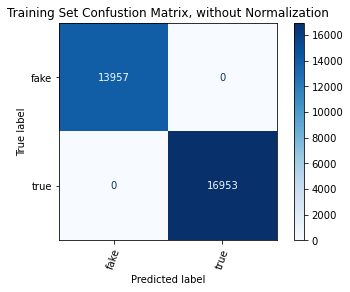

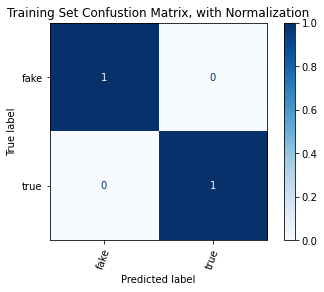

Classification Report for Test Set
              precision    recall  f1-score   support

        fake       0.99      0.96      0.97      3490
        true       0.97      0.99      0.98      4238

    accuracy                           0.98      7728
   macro avg       0.98      0.98      0.98      7728
weighted avg       0.98      0.98      0.98      7728



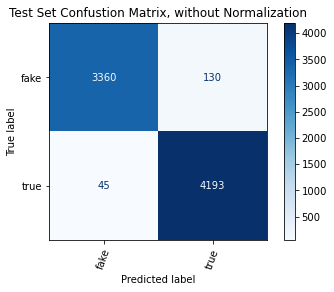

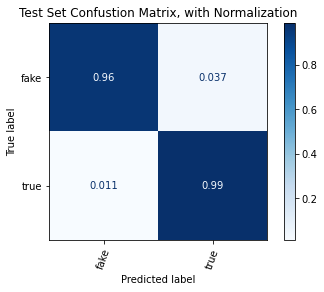

In [34]:
pipe_title_text_lc_lemma_no_sw = train_and_eval_model(X_train['title_and_text'], 
                                       X_test['title_and_text'],
                                       y_train_enc, 
                                       y_test_enc, 
                                       le.classes_, 
                                       model_helper_functions.lowercase_and_remove_stopwords, 
                                       model_helper_functions.LemmaTokenizer())

In [35]:

feat_imp_title_text_lc_lemma = pd.DataFrame(pipe_title_text_lc_lemma_no_sw['classifier'].feature_importances_, 
                                       index = pipe_title_text_lc_lemma_no_sw['bow'].get_feature_names(), 
                                       columns = ['importance']).sort_values('importance', 
                                                                             ascending=False)
feat_imp_title_text_lc_lemma.head(30)

,importance
image,0.039623
said,0.035585
via,0.021300
!,0.020607
video,0.016976
u.s.,0.014364
link,0.009856
twitter-handle,0.009378
like,0.009348
washington,0.008699


Classification Report for Training Set
              precision    recall  f1-score   support

        fake       1.00      1.00      1.00     13957
        true       1.00      1.00      1.00     16953

    accuracy                           1.00     30910
   macro avg       1.00      1.00      1.00     30910
weighted avg       1.00      1.00      1.00     30910



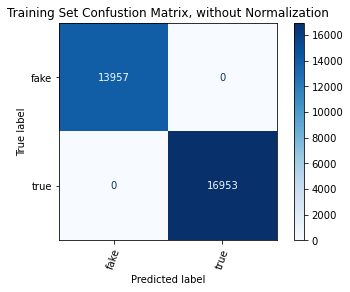

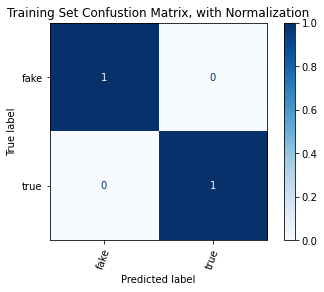

Classification Report for Test Set
              precision    recall  f1-score   support

        fake       0.99      0.97      0.98      3490
        true       0.97      0.99      0.98      4238

    accuracy                           0.98      7728
   macro avg       0.98      0.98      0.98      7728
weighted avg       0.98      0.98      0.98      7728



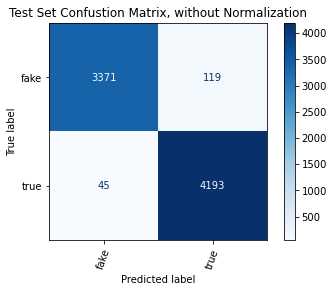

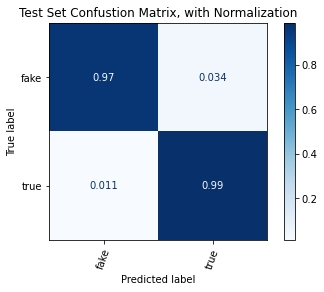

In [36]:
pipe_title_text_lc_lemma_no_sw_ng = train_and_eval_model(X_train['title_and_text'], 
                                                        X_test['title_and_text'],
                                                        y_train_enc, 
                                                        y_test_enc, 
                                                        le.classes_, 
                                                        model_helper_functions.lowercase_and_remove_stopwords, 
                                                        model_helper_functions.LemmaTokenizer(), 
                                                        ngram_range = (1, 2))

In [37]:
feat_imp_title_text_lc_lemma_no_sw_ng = pd.DataFrame(pipe_title_text_lc_lemma_no_sw_ng['classifier'].feature_importances_, 
                                       index = pipe_title_text_lc_lemma_no_sw_ng['bow'].get_feature_names(), 
                                       columns = ['importance']).sort_values('importance', 
                                                                             ascending=False)
feat_imp_title_text_lc_lemma_no_sw_ng.head(30)

,importance
image,0.020877
video,0.016767
said,0.015383
via,0.014684
!,0.011512
u.s.,0.010019
image via,0.009644
said statement,0.005603
thing,0.005241
reuters,0.004974


In [38]:
def lowercase_and_only_stopwords(doc):
    """Remove stopwords and lowercase tokens"""
    stop_words = stopwords.words('english')
    return [token.lower() for token in doc if token.lower() in stop_words]

Classification Report for Training Set
              precision    recall  f1-score   support

        fake       1.00      1.00      1.00     13957
        true       1.00      1.00      1.00     16953

    accuracy                           1.00     30910
   macro avg       1.00      1.00      1.00     30910
weighted avg       1.00      1.00      1.00     30910



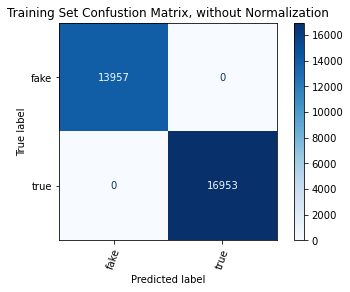

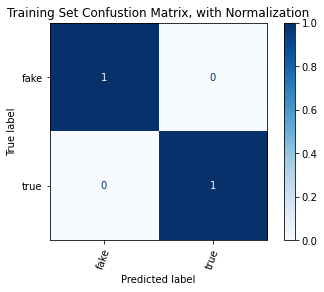

Classification Report for Test Set
              precision    recall  f1-score   support

        fake       0.91      0.87      0.89      3490
        true       0.89      0.93      0.91      4238

    accuracy                           0.90      7728
   macro avg       0.90      0.90      0.90      7728
weighted avg       0.90      0.90      0.90      7728



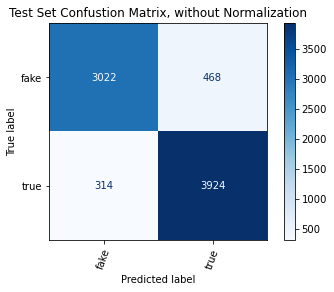

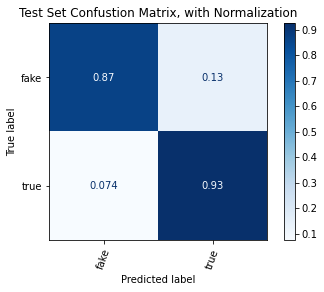

In [39]:
pipe_title_text_lc_only_sw = train_and_eval_model(X_train['title_and_text'], 
                                                        X_test['title_and_text'],
                                                        y_train_enc, 
                                                        y_test_enc, 
                                                        le.classes_, 
                                                        lowercase_and_only_stopwords, 
                                                        model_helper_functions.passthrough)

In [40]:
feat_imp_title_text_lc_only_sw = pd.DataFrame(pipe_title_text_lc_only_sw['classifier'].feature_importances_, 
                                       index = pipe_title_text_lc_only_sw['bow'].get_feature_names(), 
                                       columns = ['importance']).sort_values('importance', 
                                                                             ascending=False)
feat_imp_title_text_lc_only_sw.head(30)

,importance
you,0.068680
on,0.067182
just,0.048542
in,0.036808
its,0.033209
this,0.032984
here,0.032964
the,0.027646
is,0.025285
what,0.024428


Classification Report for Training Set
              precision    recall  f1-score   support

        fake       0.82      0.83      0.82     13957
        true       0.86      0.85      0.85     16953

    accuracy                           0.84     30910
   macro avg       0.84      0.84      0.84     30910
weighted avg       0.84      0.84      0.84     30910



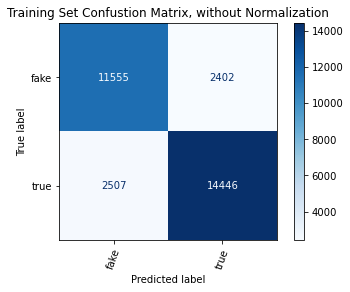

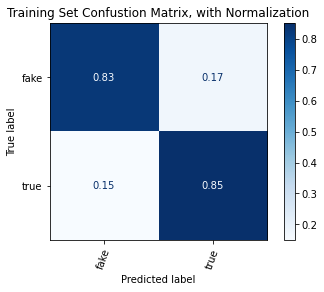

Classification Report for Test Set
              precision    recall  f1-score   support

        fake       0.82      0.82      0.82      3490
        true       0.85      0.85      0.85      4238

    accuracy                           0.84      7728
   macro avg       0.84      0.84      0.84      7728
weighted avg       0.84      0.84      0.84      7728



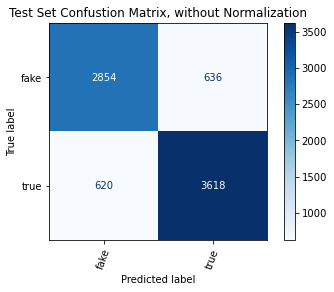

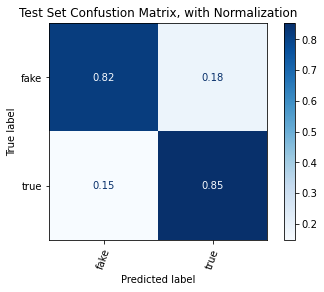

In [41]:
pipe_title_text_lc_only_sw_mdf = train_and_eval_model(X_train['title_and_text'], 
                                                        X_test['title_and_text'],
                                                        y_train_enc, 
                                                        y_test_enc, 
                                                        le.classes_, 
                                                        lowercase_and_only_stopwords, 
                                                        model_helper_functions.passthrough,
                                                 min_samples_split = 0.1)

In [42]:
feat_imp_title_text_lc_only_sw_mdf = pd.DataFrame(pipe_title_text_lc_only_sw_mdf['classifier'].feature_importances_, 
                                       index = pipe_title_text_lc_only_sw_mdf['bow'].get_feature_names(), 
                                       columns = ['importance']).sort_values('importance', 
                                                                             ascending=False)
feat_imp_title_text_lc_only_sw_mdf.head(30)

,importance
you,0.147318
just,0.086934
here,0.077032
on,0.070471
its,0.061336
what,0.060544
this,0.054320
so,0.054299
is,0.035789
didn,0.030841


In [43]:
param_grid = {'classifier__min_samples_split': [0.005, 0.01, 0.05, 0.1]}

In [44]:
def train_and_eval_grid_search(X_train, X_test, y_train_enc, y_test_enc, classes_,
                        preprocessor, tokenizer, max_df=1.0, ngram_range = (1, 1)):
                               
    pipeline = Pipeline([
                        ('bow',CountVectorizer(min_df = 5, 
                                               preprocessor = preprocessor, 
                                               tokenizer = tokenizer, 
                                               max_df = max_df, 
                                               ngram_range = ngram_range)),  
                        ('classifier', RandomForestClassifier(n_jobs = -1, 
                                                              random_state = RANDOM_STATE)),
                        ])

    gs = GridSearchCV(estimator=pipeline, param_grid=param_grid, n_jobs=-1)

    gs.fit(X_train,y_train_enc)

    model_helper_functions.confustion_matrix_and_classification_report(gs.best_estimator_, 
                                                X_train, 
                                                y_train_enc, 
                                                classes_, 
                                               'Training')

    model_helper_functions.confustion_matrix_and_classification_report(gs.best_estimator_, 
                                                X_test, 
                                                y_test_enc, 
                                                classes_,
                                                'Test')




    return gs

In [45]:
gs = train_and_eval_grid_search(X_train['title_and_text'], 
                                                        X_test['title_and_text'],
                                                        y_train_enc, 
                                                        y_test_enc, 
                                                        le.classes_, 
                                                        lowercase_and_only_stopwords, 
                                                        model_helper_functions.passthrough)

exception calling callback for <Future at 0x281166ccc10 state=finished raised BrokenProcessPool>
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "C:\Users\SHUBHAM KUMAR SINGH\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 407, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "C:\Users\SHUBHAM KUMAR SINGH\anaconda3\lib\multiprocessing\queues.py", line 122, in get
    return _ForkingPickler.loads(res)
AttributeError: 'WordListCorpusReader' object has no attribute '_unload'
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Users\SHUBHAM KUMAR SINGH\anaconda3\lib\site-packages\joblib\externals\loky\_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "C:\Users\SHUBHAM KUMAR SINGH\anaconda3\lib\site-packages\joblib\parallel.py", line 359, in __call__
    self.parallel.dispatch_next()
 

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [ ]:
gs.best_params_

In [ ]:
feat_imp_gs = pd.DataFrame(gs.best_estimator_['classifier'].feature_importances_, 
                                       index = gs.best_estimator_['bow'].get_feature_names(), 
                                       columns = ['importance']).sort_values('importance', 
                                                                             ascending=False)
feat_imp_gs.head(30)

In [ ]:

# using expanded stopwords list from https://gist.github.com/sebleier/554280

gist_file = open(DATA_PATH + "gist_stopwords.txt", "r")
try:
    content = gist_file.read()
    expanded_stopwords = content.split(",")
finally:
    gist_file.close()

In [ ]:
def lowercase_and_only_expanded_stopwords(doc):
    """Remove stopwords and lowercase tokens"""
    stop_words = expanded_stopwords
    return [token.lower() for token in doc if token.lower() in stop_words]

In [ ]:
pipe_expanded_sw = train_and_eval_model(X_train['title_and_text'], 
                                                        X_test['title_and_text'],
                                                        y_train_enc, 
                                                        y_test_enc, 
                                                        le.classes_, 
                                                        lowercase_and_only_expanded_stopwords, 
                                                        model_helper_functions.passthrough,
                                                 min_samples_split = 0.005)

In [ ]:
feat_imp_expanded_sw = pd.DataFrame(pipe_expanded_sw['classifier'].feature_importances_, 
                                       index = pipe_expanded_sw['bow'].get_feature_names(), 
                                       columns = ['importance']).sort_values('importance', 
                                                                             ascending=False)
feat_imp_expanded_sw.head(30)

In [ ]:
expanded_stopwords.remove('via')

In [ ]:
pipe_expanded_sw_no_via = train_and_eval_model(X_train['title_and_text'], 
                                                        X_test['title_and_text'],
                                                        y_train_enc, 
                                                        y_test_enc, 
                                                        le.classes_, 
                                                        lowercase_and_only_expanded_stopwords, 
                                                        model_helper_functions.passthrough,
                                                 min_samples_split = 0.005)

In [ ]:
feat_imp_expanded_sw_no_via = pd.DataFrame(pipe_expanded_sw_no_via['classifier'].feature_importances_, 
                                       index = pipe_expanded_sw_no_via['bow'].get_feature_names(), 
                                       columns = ['importance']).sort_values('importance', 
                                                                             ascending=False)
feat_imp_expanded_sw_no_via.head(30)